In [105]:
# also parse tag отдых

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
from sklearn.metrics.pairwise import cosine_similarity
import os
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import seaborn as sns
from pyvis.network import Network
import re

In [2]:
PATH_TO_DATA = 'jsons/new/'

In [3]:
# for example lets look at first file мебель.html
furniture = os.listdir(PATH_TO_DATA)[0]

In [4]:
with open(os.path.join(PATH_TO_DATA, furniture), 'r') as f:
    tmp = json.load(f)

In [5]:
bad_items = list()
no_tags_items = list()
for item in tmp['GraphImages']:
    if 'tags' not in item.keys():
        no_tags_items.append(item)
    else:
        if len(item['tags']) == 0:
            bad_items.append(item)
len(bad_items), len(no_tags_items)

(103, 23)

In [6]:
for item in bad_items:
    tmp['GraphImages'].remove(item)
for item in no_tags_items:
    tmp['GraphImages'].remove(item)
len(tmp['GraphImages'])

874

In [124]:
all_set_of_tags = list()

for item in tmp['GraphImages']:
    all_set_of_tags.extend(list(map(lambda x: x.lower(), item['tags'])))

len(all_set_of_tags)

15640

In [125]:
counter = Counter(all_set_of_tags)
counter.most_common()

[('мебель', 867),
 ('кровать', 219),
 ('диван', 172),
 ('москва', 167),
 ('мебельназаказ', 165),
 ('мягкаямебель', 159),
 ('саратов', 137),
 ('мебельсаратов', 126),
 ('низкиецены', 125),
 ('качественнаямебель', 124),
 ('нестандартнаякровать', 123),
 ('дивансаратов', 123),
 ('недорогаякачественнаямебель', 123),
 ('мегамебель', 123),
 ('ортопедическиедиваны', 123),
 ('мягкаякровать', 123),
 ('кухни', 118),
 ('крым', 117),
 ('самара', 115),
 ('стулья', 112),
 ('кухня', 109),
 ('интерьер', 105),
 ('столы', 98),
 ('дизайн', 96),
 ('москвасити', 95),
 ('краснодар', 95),
 ('шкаф', 92),
 ('грозныи', 90),
 ('доставка', 86),
 ('чечня', 85),
 ('moscow', 83),
 ('воронеж', 82),
 ('ставрополь', 82),
 ('владикавказ', 76),
 ('астрахань', 75),
 ('волгоград', 74),
 ('мебельдляспальни', 72),
 ('ростов', 71),
 ('грозный', 65),
 ('спальни', 65),
 ('сургут', 64),
 ('мебельдлядома', 62),
 ('нальчик', 61),
 ('спб', 60),
 ('шкафкупе', 59),
 ('черкесск', 59),
 ('уфа', 59),
 ('мебельоптом', 58),
 ('спальная', 57

In [126]:
df = pd.DataFrame(counter.most_common(), columns=['tag', 'count'], index=[tag for tag, _ in counter.most_common()])
df = df.drop(['tag'], axis=1)
df

,count
мебель,867
кровать,219
диван,172
москва,167
мебельназаказ,165
мягкаямебель,159
саратов,137
мебельсаратов,126
низкиецены,125
качественнаямебель,124


<Figure size 1152x576 with 0 Axes>

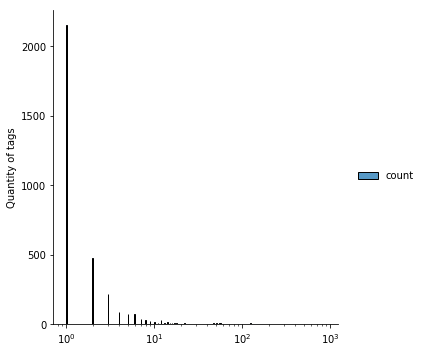

In [127]:
fig = plt.figure(figsize=(16, 8))
sns.displot(df, bins=400, log_scale=True)
plt.ylabel('Quantity of tags')
plt.show();

In [132]:
val = 100
df.shape[0], df[df['count'] >= val].shape[0]

(3377, 22)

## EDA

In [68]:
pop_tags = [tag for tag, quantity in counter.most_common() if quantity >= val]

In [69]:
adj = defaultdict(set)

for post in tqdm(tmp['GraphImages']):
    for tag in pop_tags:
        for inner_tag in pop_tags:
            if tag != inner_tag and tag in post['tags'] and inner_tag in post['tags']:
                adj[tag].add(inner_tag)
for key in adj:
    adj[key] = list(adj[key])

In [70]:
G = nx.from_dict_of_lists(adj)

In [71]:
def sim_matrices(G):
    adj = nx.to_numpy_array(G) # или nx.adjacency_matrix(G)
    pears = np.corrcoef(adj)
    jak = np.zeros(adj.shape)
    for i, j, k in nx.jaccard_coefficient(nx.from_numpy_array(adj)):
        jak[i, j] = k
        jak[j, i] = k
    cs = cosine_similarity(adj)
    return adj, pears, jak, cs

In [72]:
A, corr, J, cos = sim_matrices(G)

In [73]:
# also look at approach of monitoring - market basket

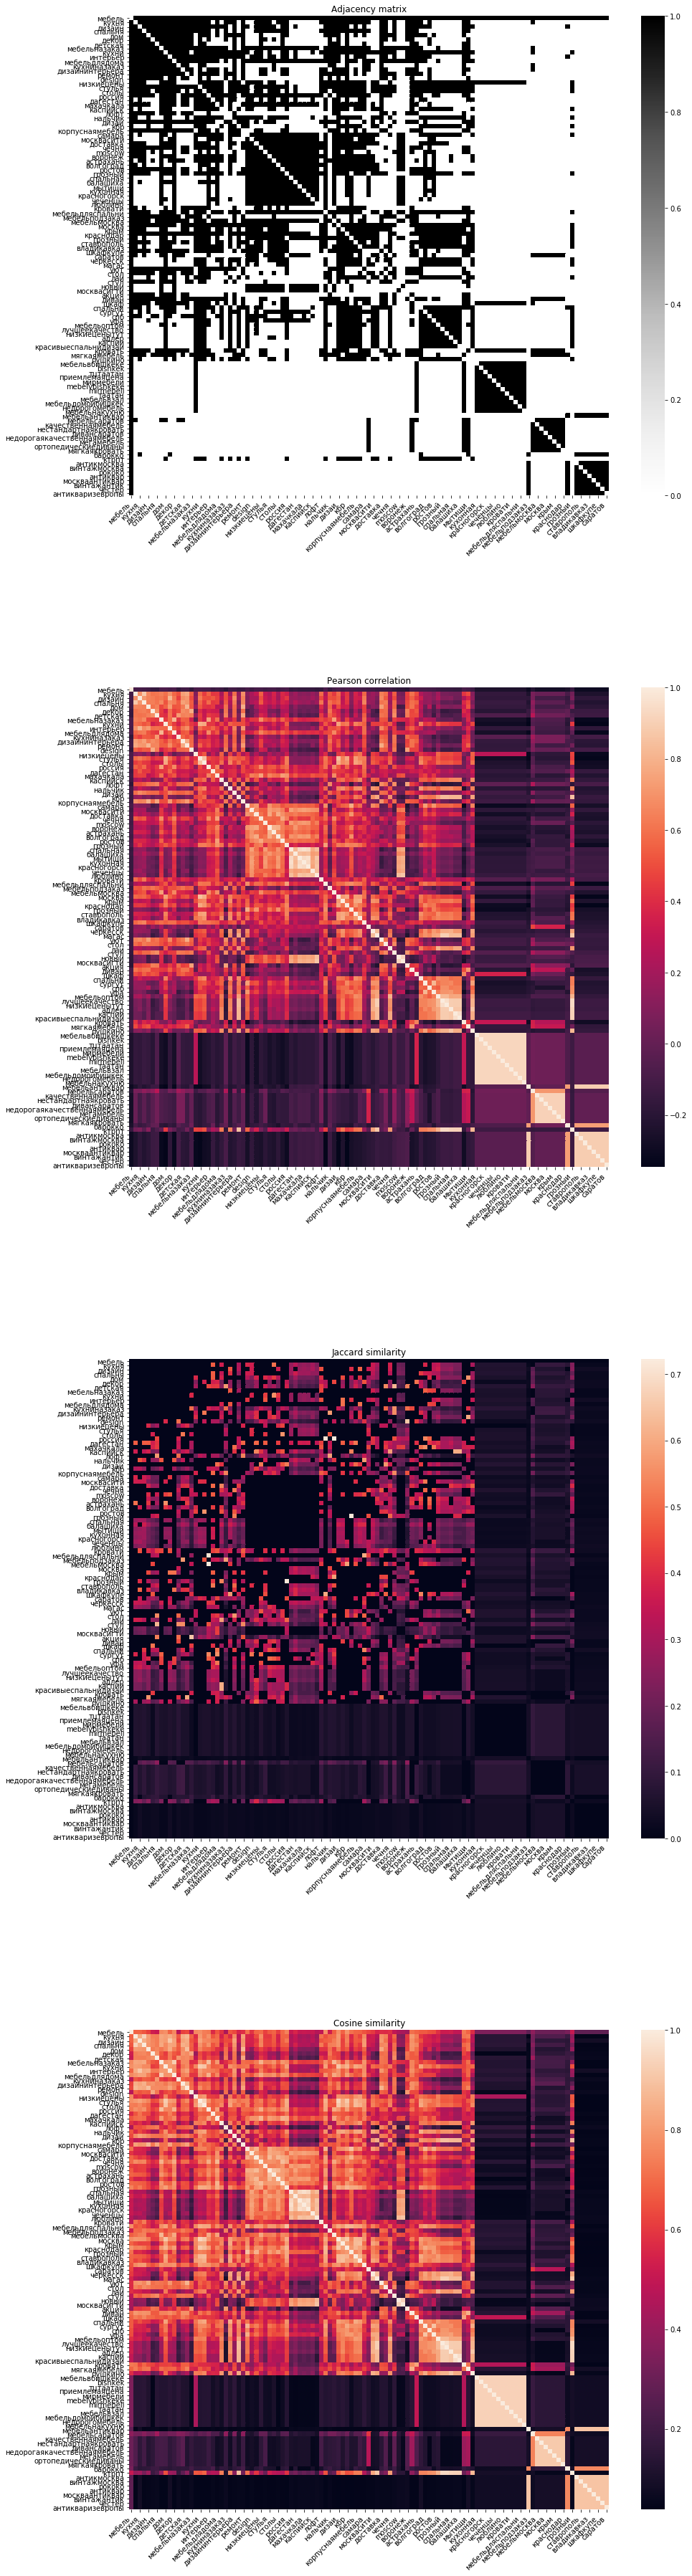

In [74]:
fig = plt.figure(figsize=(16, 16*4))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
cases = [[1, A, plt.cm.Greys, 'Adjacency matrix'], 
         [2, corr, None, 'Pearson correlation'], 
         [3, J, None, 'Jaccard similarity'], 
         [4, cos, None, 'Cosine similarity'], ]
for i, matrix, cmap, t in cases:
    plt.subplot(4, 1, i)
    hmap = sns.heatmap(
        matrix,
        cmap=cmap,
        square=True,
        yticklabels=list(G.nodes))
    hmap.set_xticklabels(
        labels=list(G.nodes), 
        rotation=45, 
        horizontalalignment='right')
    plt.title(t)

In [75]:
g = Network(800, 600, notebook=True)
g.toggle_hide_edges_on_drag(False)
g.barnes_hut()
g.from_nx(G)
g.show('мебель.html')

In [76]:
G.number_of_nodes()

111

# All in one

In [7]:
bad_tags = set(['взаимнаяподписка', 'like4like', 'калининград', 'харьков', 'днепр', 'запорожье', 'москва', 'грозный',
            'сибирь', 'подписказаподписку', 'лайкивзаимно', 'сочи', 'адлер', 'инстаграм', 'followers', 'санктпетербург',
            'владикавказ', 'сургут', 'красноярск', 'краснодарскийкрай', 'казань', 'взаимныелайки', 'лайк', 'киев',
            'подписка', 'liketime', 'подпишись', 'instagood', 'instalike', 'ростов', 'иркутск', 'астрахань',
            'таджикистан', 'доставка', 'usa', 'дагестан', 'турция', 'одесса', 'черкесск', 'инстатаг', 'пятигорск'
            'инстаграманет', 'украина', 'розыгрыш', 'беларусь',  'ингушетия', 'moscow', 'инста', 'instatag', 
            'крым', 'ялта', 'crimea', 'лайктайм', 'лайквзаимно', 'взаимныеподписки', 'взаимныелаи',  'анапа', 'уфа'
            'followforfollowback', 'followforfollow', 'kyrgyzstan', 'махачкала', 'дербент', 'каспии', 'күршім',
            'казахстан', 'астана', 'шымкент', 'киев', 'москва', 'russia', 'instagram', 'судак', 'бесплатнаядоставка',
            'turkey', 'nursultan', 'kazakhstan', 'kz', 'алматы', 'арбат', 'устькаменогорск', 'тараз', 'пятигорск',
            'караганда','uka', 'күршім', 'устькаменогорск', 'караганда', 'чечня', 'волгоград', 'воронеж', 'саратов',
            'лайки', 'красногорск', 'самара', 'москвасигти', 'балашиха', 'чеченцы', 'взаимнаяпописка', 'люблино',
            'нальчик', 'ставрополь', 'самара', 'меблі', 'рунышымкент', 'шымкентпицца', 'гаданиешымкент', 'шымкенттатуаж',
            'шымкентруны', 'уфа', 'каспийск', 'кизляр', 'россия', 'мытищи', 'москвасити', 'moscowcity',
            'лайкнитепожалуйста', 'пушкино', 'краснодар', 'майкоп', 'новыйарбат', 'ярославль', 'грозныи', 'челябинск',
            'spb', 'msk', 'брянск', 'нурсултан', 'спб', 'ингуши', 'таатан', 'bishkek', 'тцтаатан', 'инстаграманет',
               ])

In [8]:
def read_file(file_path):
    if file_path.endswith('.json'):
        with open(file_path, 'r') as f:
            tmp = json.load(f)
        return tmp

In [9]:
def delete_bad_items(post_list):
    bad_items = list()
    no_tags_items = list()
    for item in post_list:
        if 'tags' not in item.keys():
            no_tags_items.append(item)
        else:
            if len(item['tags']) == 0:
                bad_items.append(item)
    
    for item in bad_items:
        post_list.remove(item)
    for item in no_tags_items:
        post_list.remove(item)

In [10]:
def extend_set_of_tags(post_list, all_set_of_tags):
    for item in post_list:
        all_set_of_tags.extend(list(map(lambda x: x.lower(), item['tags'])))

In [11]:
def delete_bad_tags(all_set_of_tags, pattern='(^[a-zа-я0-9]+)', bad_tags=bad_tags):
    p = re.compile(pattern)
    for tag in all_set_of_tags:
        if tag in bad_tags:
            all_set_of_tags.remove(tag)
        if not re.findall(p, tag):
            all_set_of_tags.remove(tag)
    return all_set_of_tags

In [12]:
def form_adj_dict(list_of_tags, post_list, adj, boundary=50):
    counter = Counter(list_of_tags)
    pop_tags = [tag for tag, quantity in counter.most_common() if quantity >= boundary]

    for post in tqdm(post_list):
        for tag in pop_tags:
            for inner_tag in pop_tags:
                if tag != inner_tag and tag in post['tags'] and inner_tag in post['tags']:
                    adj[tag].add(inner_tag)

In [13]:
def prepare_for_graph(boundary=50):
    all_set_of_tags = list()
    adj = defaultdict(set)
    for json_file in tqdm(os.listdir(PATH_TO_DATA)):
        if not json_file.endswith('.json'):
            continue
        f = read_file(os.path.join(PATH_TO_DATA, json_file))

        delete_bad_items(f['GraphImages'])

        extend_set_of_tags(f['GraphImages'], all_set_of_tags)
    delete_bad_tags(all_set_of_tags)

    form_adj_dict(all_set_of_tags, f['GraphImages'], adj, boundary)

    for key in adj:
        adj[key] = list(adj[key])
    return adj, all_set_of_tags

In [232]:
boundary = 50
adj, all_set_of_tags = prepare_for_graph(boundary)

In [233]:
# import pickle
# with open('all_tags_with_boundary_100.pkl', 'wb') as f:
#     pickle.dump(all_set_of_tags, f)

In [222]:
G = nx.from_dict_of_lists(adj)
G.number_of_nodes()

372

In [223]:
A, corr, J, cos = sim_matrices(G)

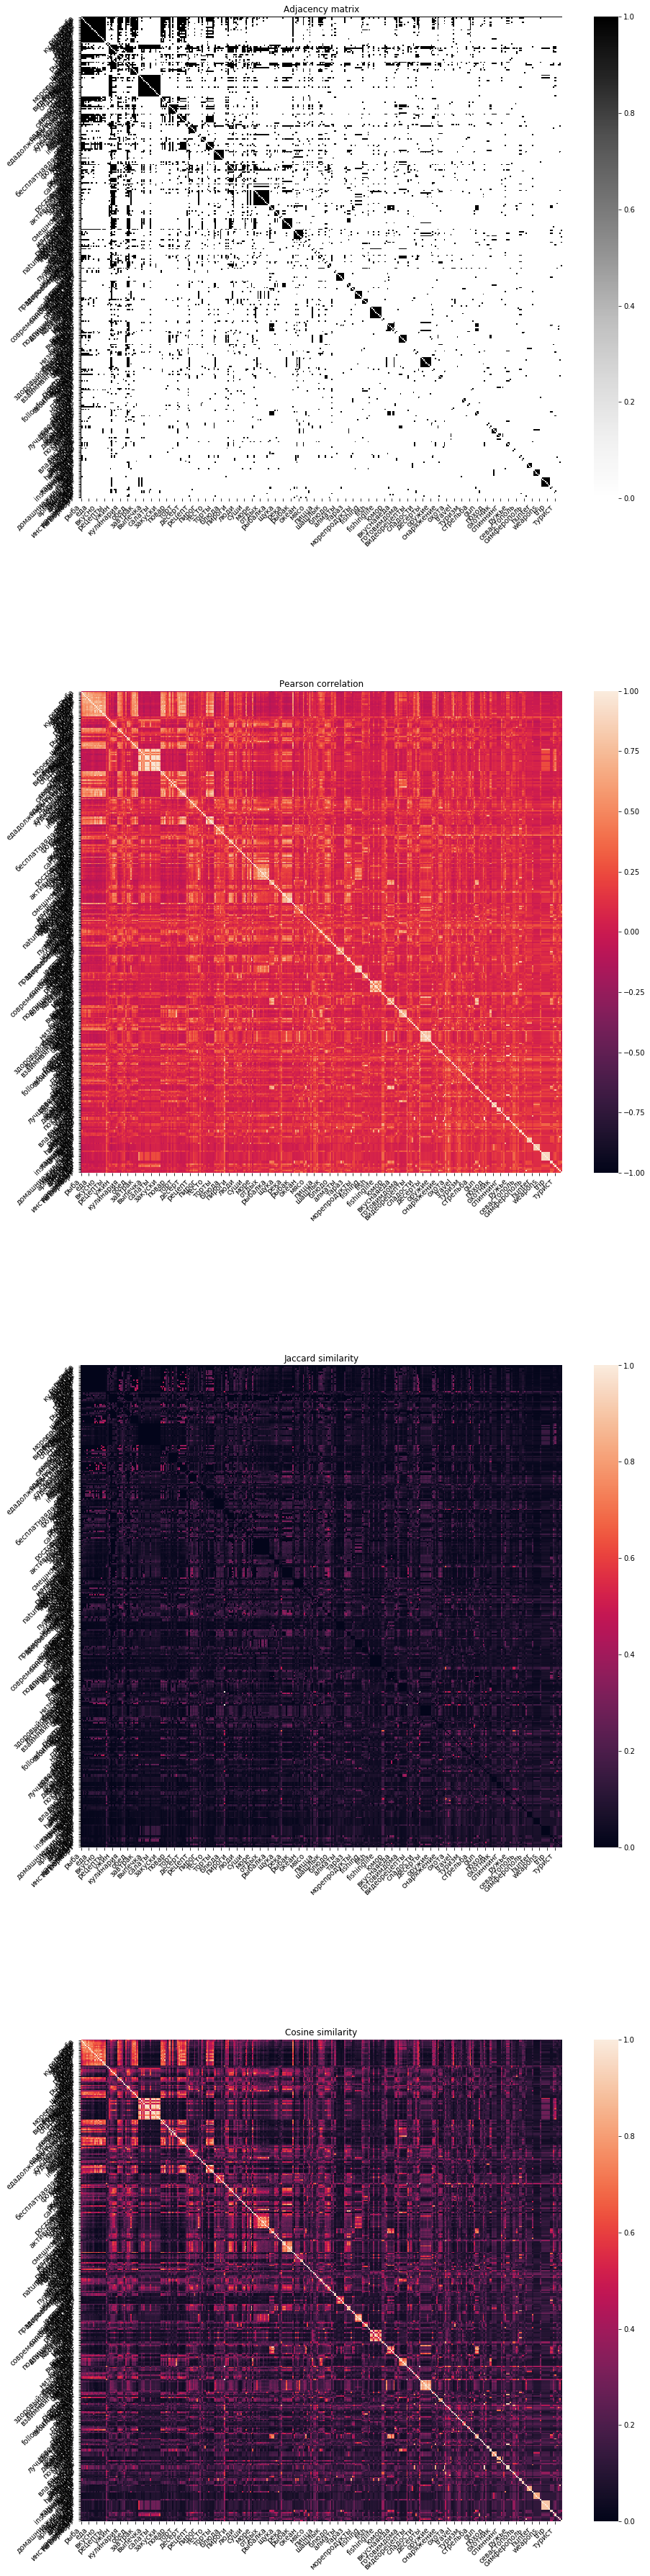

In [224]:
fig = plt.figure(figsize=(16, 16*4))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
cases = [[1, A, plt.cm.Greys, 'Adjacency matrix'], 
         [2, corr, None, 'Pearson correlation'], 
         [3, J, None, 'Jaccard similarity'], 
         [4, cos, None, 'Cosine similarity'], ]
for i, matrix, cmap, t in cases:
    plt.subplot(4, 1, i)
    hmap = sns.heatmap(
        matrix,
        cmap=cmap,
        square=True,
        yticklabels=list(G.nodes))
    hmap.set_xticklabels(
        labels=list(G.nodes), 
        rotation=45, 
        horizontalalignment='right')
    hmap.set_yticklabels(
        labels=list(G.nodes), 
        rotation=45, 
        horizontalalignment='right')
    plt.title(t)

In [225]:
ind2node = {i:tag for i, tag in enumerate(G.nodes)}
ind2node

{0: 'рыба',
 1: 'еда',
 2: 'вкусно',
 3: 'рецепты',
 4: 'ужин',
 5: 'кулинария',
 6: 'обед',
 7: 'завтрак',
 8: 'выпечка',
 9: 'салаты',
 10: 'закуски',
 11: 'повар',
 12: 'торт',
 13: 'десерт',
 14: 'рецепт',
 15: 'пирог',
 16: 'тесто',
 17: 'торты',
 18: 'блюда',
 19: 'пироги',
 20: 'люди',
 21: 'суши',
 22: 'море',
 23: 'отдых',
 24: 'рыбалка',
 25: 'щука',
 26: 'река',
 27: 'рыбак',
 28: 'океан',
 29: 'мясо',
 30: 'пицца',
 31: 'шашлык',
 32: 'блюдо',
 33: 'алматы',
 34: 'тараз',
 35: 'морепродукты',
 36: 'fishing',
 37: 'fish',
 38: 'fishinglife',
 39: 'юмор',
 40: 'вкуснаяеда',
 41: 'готовимдома',
 42: 'видеорецепты',
 43: 'сладости',
 44: 'десерты',
 45: 'оружие',
 46: 'снаряжение',
 47: 'охота',
 48: 'travel',
 49: 'туризм',
 50: 'стрельба',
 51: 'gun',
 52: 'поход',
 53: 'охотник',
 54: 'спиннинг',
 55: 'ружье',
 56: 'севастополь',
 57: 'симферополь',
 58: 'hunter',
 59: 'weapons',
 60: 'trip',
 61: 'турист',
 62: 'едаялюблютебя',
 63: 'суп',
 64: 'едадолжнабытьвкусной',
 65: 

In [221]:
for i, row in enumerate(corr):
    for j, value in enumerate(row):
        if abs(value) >= 0.8 and i != j:
            print(ind2node[i], ind2node[j], value)

рыба экология -1.0
рыба мечта -1.0
рыба саратов -1.0
ужин обед 0.8385481602338805
обед ужин 0.8385481602338805
выпечка суп 0.8001917805537005
выпечка блины 0.830676853500276
повар десерт 0.8434965077753673
повар пирог 0.8972009913692877
повар тесто 0.8769726967929911
повар оладьи 0.8334497852000637
повар картошка 0.8093933241557046
десерт повар 0.8434965077753674
десерт пирог 0.8447283901624365
десерт тесто 0.8040055188228127
пирог повар 0.8972009913692877
пирог десерт 0.8447283901624364
пирог тесто 0.8544837913702122
пирог оладьи 0.8120618081182644
тесто повар 0.8769726967929911
тесто десерт 0.8040055188228127
тесто пирог 0.8544837913702121
тесто оладьи 0.8252651864493465
тесто макароны 0.8252651864493465
тесто картошка 0.8674293933420507
тесто лайфхак 0.8288297531851953
оружие снаряжение 0.8061249937135566
оружие стрельба 0.8061249937135566
оружие gun 0.8061249937135566
оружие поход 0.8061249937135566
оружие ружье 0.8061249937135566
оружие симферополь 0.8061249937135566
оружие weapon

artist художник 0.8294528594947932
artist artwork 0.8839966842539488
ручка sketch 0.8453439804095219
ручка скетч 0.8214590999890584
ручка sketchbook 0.9305322128851542
sketchbook sketch 0.8453439804095219
sketchbook скетч 0.8214590999890584
sketchbook ручка 0.9305322128851542
новинка одежда 0.8133495582407657
новинка обувь 0.8133495582407657
эстетика followforfollowback 0.8263670000244699
эстетика лаи 0.941619585687382
эстетика mood 0.941619585687382
эстетика amazing 0.941619585687382
эстетика подписки 0.941619585687382
world релакс 0.8861340679522501
релакс world 0.8861340679522501
похудение тренер 0.9416195856873821
тренер похудение 0.9416195856873821
girl car 0.906320825988416
girl nails 0.906320825988416
car girl 0.906320825988416
car nails 0.906320825988416
nails girl 0.906320825988416
nails car 0.906320825988416
mood followforfollowback 0.8263670000244699
mood лаи 0.941619585687382
mood эстетика 0.941619585687382
mood amazing 0.941619585687382
mood подписки 0.941619585687382
amaz

In [164]:
g = Network(1280, 1024, notebook=True)
g.toggle_hide_edges_on_drag(False)
g.barnes_hut()
g.from_nx(G)

g.show('все_в_одном.html')

KeyError: 'title'

# Another approach

In [14]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [25]:
busket = list()
for json_file in os.listdir(PATH_TO_DATA):
        if not json_file.endswith('.json'):
            continue
        f = read_file(os.path.join(PATH_TO_DATA, json_file))

        delete_bad_items(f['GraphImages'])
        
        for post_tags in tqdm(f['GraphImages']):
            try:
                delete_bad_tags(post_tags['tags'])
            except ValueError:
                pass
            busket.append(list(map(lambda x: x.lower(), post_tags['tags'])))

len(busket)

18926

In [26]:
all_tags_in_one = list()
for post in busket:
    all_tags_in_one.extend(list(map(lambda x: x.lower(), post)))
counter = Counter(all_tags_in_one)

In [27]:
rare_tags = set([tag for tag, quantity in counter.most_common() if quantity <= 100])
print(len(rare_tags), len(counter))
for post in tqdm(busket):
    for el in post:
        if el in rare_tags:
            post.remove(el)

66441 66807


In [28]:
pattern='(^[a-zа-я0-9]+)'
for el in busket:
    p = re.compile(pattern)
    for tag in el:
        if tag in bad_tags:
            el.remove(tag)
        if not re.findall(p, tag):
            try:
                el.remove(tag)
            except ValueError:
                print(tag)
    if len(el) == 0:
        busket.remove(el)
len(busket)

18687

In [29]:
all_tags_in_one = list()
for post in busket:
    all_tags_in_one.extend(list(map(lambda x: x.lower(), post)))
counter = Counter(all_tags_in_one)
len(counter)

36161

In [97]:
# busket

In [30]:
oht = TransactionEncoder()
oht_ary = oht.fit(busket).transform(busket)

In [31]:
d = pd.DataFrame(oht_ary,columns=oht.columns_)
r_test = apriori(d,min_support=0.00001, use_colnames=True, max_len=2, low_memory=True).sort_values(by='support', ascending=False)
res_test = association_rules(r_test, min_threshold=0.00001).sort_values(['antecedent support','confidence'], ascending=False)

In [32]:
res_test

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
11,(красота),(здоровье),0.123990,0.059507,0.022904,0.184722,3.104220,0.015525,1.153586
21,(красота),(природа),0.123990,0.058383,0.020603,0.166163,2.846096,0.013364,1.129258
29,(красота),(любовь),0.123990,0.049500,0.017873,0.144152,2.912180,0.011736,1.110595
47,(красота),(стиль),0.123990,0.048055,0.016696,0.134657,2.802153,0.010738,1.100078
59,(красота),(мода),0.123990,0.046235,0.015679,0.126457,2.735064,0.009947,1.091834
69,(красота),(косметика),0.123990,0.050623,0.015144,0.122141,2.412731,0.008867,1.081468
79,(красота),(love),0.123990,0.037352,0.014502,0.116962,3.131320,0.009871,1.090154
84,(красота),(жизнь),0.123990,0.035640,0.014020,0.113077,3.172785,0.009601,1.087310
92,(красота),(фото),0.123990,0.039707,0.013699,0.110488,2.782593,0.008776,1.079573
139,(красота),(спорт),0.123990,0.073259,0.012683,0.102287,1.396235,0.003599,1.032335


In [101]:
#  лучше использовать только support & confidence
# support -  совстречаемость (когда оба значения встречаются в одной корзине)
# confidence - условная вероятность коллокации (второй элемент, при условии первого)
# можно также использовать по отдельности support - 

In [33]:
r_test

,support,itemsets
20039,0.123990,(красота)
24863,0.081447,(одежда)
30995,0.073259,(спорт)
15892,0.067052,(дом)
22262,0.061112,(мебель)
17217,0.059507,(здоровье)
23457,0.059239,(музыка)
27683,0.058383,(природа)
20731,0.057152,(кухня)
25344,0.054690,(оружие)


In [34]:
import pickle
with open('busket_analys_collocation.pkl', 'wb') as f:
    pickle.dump(res_test, f)

In [35]:
with open('busket_analys_single.pkl', 'wb') as f:
    pickle.dump(r_test, f)